In [1]:
from docplex.mp.model import Model  #导出库，只用这一个就够了
import matplotlib.pyplot as plt#选取了用户47的365天的数据
import numpy as np
import pandas as pd
import csv
import cplex
from cplex.exceptions import CplexError
import time
import math
#from openpyxl import Workbook
import xlrd
import torch
from torch import nn
#from matplotlib.animation import FuncAnimation
#import matplotlib.animation as animation
import os

In [3]:
#def RNN_train(year,user):
    TIME_STEP = 48  # RNN时间步长
    INPUT_SIZE = 336  # RNN输入尺寸
    INIT_LR = 0.01  # 初始学习率
    N_EPOCHS = 300  # 训练回数
    Batch_size=1
    batch_nums=301
    
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    
    GG_array,Total_Load_array,pv_size=Read_year(year,user)
    
    soc_y=read_data("soc-"+str(year)+"-"+str(user)+"-")
    data_365=samples(T_tou,soc_y,Total_Load_array,GG_array)
    a=np.array(data_365[1:302]).transpose((1,0,2))
    soc_label=[[]for i in range(360)]
    for i in range(360):
        for j in np.arange(1,48):
            soc_label[i].append(soc_y[i+1][j])
        soc_label[i].append(soc_y[i+2][0])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    class RNN(nn.Module):
        def __init__(self):
            super(RNN, self).__init__()
            self.rnn = nn.RNN(
                input_size=INPUT_SIZE,
                hidden_size=20,  # RNN隐藏神经元个数20
                num_layers=1,  # RNN隐藏层个数
            )
            self.out = nn.Linear(20, 1).to(device)#全连接层

        def forward(self, x, h):
            out, h = self.rnn(x, h)
            prediction = self.out(out)
            return prediction, h
    
    rnn = RNN()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=INIT_LR)
    loss_func = nn.MSELoss()
    h_state = None  # 初始化隐藏层
    train_loss=[]
    plt.figure()
    plt.ion()
    steps=[i for i in range(48*1)]
    loss_min=20
    lr_list = []
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100,150,200,250,300], gamma=0.6)
    for step in range(N_EPOCHS):
        error=0.0
        in_start = time.time()
        for batch_num in range(batch_nums):#此处分成了43个batch 
            x=torch.from_numpy(np.array(a[:,batch_num,np.newaxis])).float().to(device)
            y=torch.from_numpy(np.array(soc_label[batch_num])[:,np.newaxis,np.newaxis]).float().to(device)
            prediction, h_state = rnn(x, h_state)  # RNN输出（预测结果，隐藏状态）
            print(prediction.shape)
            h_state = h_state.detach()  # 这一行很重要，将每一次输出的中间状态传递下去(不带梯度)，将h_state分离出来，同时不影响后向计算
            loss = loss_func(prediction, y)
            error += loss
            #print("epoch:",step,"batch_num:",batch_num,"loss:",loss)
            optimizer.zero_grad()#清零，模型的参数梯度设成0
            loss.backward()
            optimizer.step()
            scheduler.step()  # 学习率更新
            lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
            #torch.save(rnn.state_dict(), 'C:/Users/chenxihui/Desktop/code/project/rnn.pt')
            if(loss<0.001):
                plt.cla()
                plt.plot(steps, np.array(soc_label[batch_num]).flatten(), 'r-')
                plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
                plt.draw()
                plt.pause(0.1)
        in_time = time.time() - in_start
        error /= batch_nums
        train_loss.append(error)
        print("Epoch: " + str(step) + ", Loss = " + str(error))
    print("Finished. Time = " + str(time.time() - in_start))
    print("save model...")
    if not os.path.exists("./model/"):
        os.makedirs("./model/")
    filepath = "./model/rnn"+str(year)+"-"+str(user)+".model"
    torch.save({"model_state_dict" : rnn.state_dict(),
            "optimizer_state_dict" : optimizer.state_dict()},
            filepath)   
    print("Model has been saved.")
#print("h:",h_state)
    plt.ioff()
    plt.show()

In [2]:
 #read file, for example
file_path = 'C:/Users/chenxihui/Desktop/code/project/2012.csv'
file = open(file_path)
data = []
for i in file.readlines():
    data.append(i)
file.close()

new_data = []
for row in data:
    tmp = row.strip('\n')  #去掉每行最后的回车符
    tmp = tmp.split(',')   #根据','来分割字符串，使之成为含有一个个数据的列表
    new_data.append(tmp)   #new_data的每一行数据就是一个列表
select_data = []

length=len(new_data)
for i in range(length):
    if(new_data[i][0]=='2'):#PVsize为8kwp
        select_data.append(new_data[i][3:])#[3:]

GC=[]
CL=[]
GG=[]
Battery=[]
Length_select_data = len(select_data)
for i in range(Length_select_data):
    if(select_data[i][0]=='GC'):
        GC.append(select_data[i][2:])
    elif(select_data[i][0]=='CL'):
        CL.append(select_data[i][2:])
    else:
        GG.append(select_data[i][2:])
        
Total_Load=[]
temp=[]
a=0.0
for i in range(Length_select_data):
    if(select_data[i][0]=='GC' and select_data[i+1][0]=='CL'):
        for j in range(len(select_data[i][2:])):
            a=pd.to_numeric(select_data[i][j+2])+pd.to_numeric(select_data[i+1][j+2])
            temp.append(a)
        Total_Load.append(temp)
    elif(select_data[i][0]=='GC' and select_data[i+1][0]!='CL'):
        Total_Load.append(select_data[i][2:])
    temp=[]
    
GC_temp=np.array(GC)
GC_array=[]
GC_array = GC_temp.astype(np.float)

GG_temp=np.array(GG)
GG_array=[]
GG_array = GG_temp.astype(np.float)*2

Total_Load_temp=np.array(Total_Load)
Total_Load_array=[]
Total_Load_array = Total_Load_temp.astype(np.float32)*2#功率


In [12]:
float(new_data[13][1])

3.78

In [4]:
pg_bar=np.max(Total_Load_array)
T_flat=0.235018
T_fit=0.09
T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]

NameError: name 'Total_Load_array' is not defined

In [4]:
def milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar):
    expression=0
    tfit=[]
    model = Model()####对变量命名并且给出上下界
    var_list = np.arange(0,48,1)
    X1 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X1')#代表pg_import(pg+)，功率
    X2 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X2')#代表pg_export(pg-)
    Y1 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y1')#代表充电功率（pb+）
    Y2 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y2')#代表放电功率（pb-）
    dg=model.binary_var_list(var_list,name='dg')#决策变量电网电力流向（0：用户到电网）
    sb=model.binary_var_list(var_list,name='sb')#决策变量电池充电状态（0：放电）
    eb=model.continuous_var_list(var_list,lb=0,name='eb')#电池容量SOC
    tou=[]
    tou.extend(T_tou[i:])
    tou.extend(T_tou[0:i])#输入分时电价
    
    for j in range(48):
        #tfit.append(T_fit)
        expression+=tou[j]*X1[j]*dh#X1为pg+,X2为pg-,Y1为pb+,Y2为pb-
        expression-=T_fit*X2[j]*dh
    #约束条件（2）
        if(j+i<48):
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d][j+i]-efficiency_i*GG_array[d][j+i])
        else:
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d+1][j+i-48]-efficiency_i*GG_array[d+1][j+i-48])
        
    #约束条件（3）
        bat_state.append(bat_state[-1]+dh*efficiency_c*Y1[j]-(dh/efficiency_c)*Y2[j])#约束条件（3）
        eb[j]=bat_state[-1]
        model.add_constraint(eb[j]<=bat_max)#约束条件（12）
        model.add_constraint(eb[j]>=0)#约束条件（12）
    #约束条件（4）
        model.add_constraint(X1[j]-pg_bar*dg[j]<=0)
    #约束条件（5）
        model.add_constraint(X2[j]+pg_bar*dg[j]<=pg_bar)
    #约束条件（6）
        model.add_constraint(Y1[j]-pb_bar*sb[j]<=0)
    #约束条件（7）
        model.add_constraint(Y2[j]+pb_bar*sb[j]<=pb_bar)
    model.minimize(expression)#目标函数    
    sol = model.solve() #输出解
    temp = sol.get_all_values()
    return temp,bat_state[0]

In [5]:
def MILP_365(Total_Load_array,GG_array):
    days=364
    pb_bar=5
    bat_max=14
    efficiency_i=0.9
    efficiency_c=0.95
    dh=0.5
    pg_bar=float(np.max(Total_Load_array))
    T_flat=0.235018
    T_fit=0.09
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    init_state=14
    bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
    pg_import=[[] for _ in range(days)]
    pg_export=[[] for _ in range(days)]
    pb_c=[[] for _ in range(days)]
    pb_d=[[] for _ in range(days)]
    soc=[[] for _ in range(days)]
    soc[0]=[0.5*bat_max]
    a=time.time()
    for d in np.arange(0,days,1): 
        for i in range(48):
        #print(bat_state)
            temp=[]
            temp,before=milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar)
        #print(temp[96])
            if(i==47 and d<days-1):
                soc[d+1].append(abs(before+dh*efficiency_c*temp[96]-(dh/efficiency_c)*temp[144]))
            elif(i<47):     
                soc[d].append(abs(before+dh*efficiency_c*temp[96]-(dh/efficiency_c)*temp[144]))#bat_state保存的是滚动域内48个时刻都要满足电池约束，所以一个遍历完后得
        #重置，而SOC是要输出的值
            bat_state=[]
            bat_state.append(soc[d][-1])
        #d=bat_state[-1]+0.455*a[0]-(0.5/0.91)*a[0]
        #print(bat_state[-1])
            pg_import[d].append(abs(temp[0]))
            pg_export[d].append(abs(temp[48]))
            pb_c[d].append(abs(temp[96]))
            pb_d[d].append(abs(temp[144]))
    return soc,pg_import,pg_export,pb_c,pb_d

In [31]:
s=time.time()
soc,pg_import,pg_export,pb_c,pb_d=MILP_365(Total_Load_array,GG_array)
e=time.time()
print("time:",e-s)
#soc=soc[:336]#作为标准值，是第184天到191天的
#soc_test=soc[48:96]

IndexError: index 284 is out of bounds for axis 0 with size 284

In [6]:
def save(data,path):
    wb = Workbook()
    ws = wb.active # 激活 worksheet
    [h, l] = np.array(data).shape  # h为行数，l为列数
    for i in range(h):
        row = []
        for j in range(l):
            row.append(format(data[i][j],'.4f'))
        ws.append(row)
    wb.save(path)

In [80]:
save(soc,"C:/Users/chenxihui/Desktop/code/project/processed_data/soc.xlsx")

In [81]:
save(pg_import,"C:/Users/chenxihui/Desktop/code/project/processed_data/pg_import.xlsx")

In [82]:
save(pg_export,"C:/Users/chenxihui/Desktop/code/project/processed_data/pg_export.xlsx")

In [83]:
save(pb_c,"C:/Users/chenxihui/Desktop/code/project/processed_data/pb_c.xlsx")

In [84]:
save(pb_d,"C:/Users/chenxihui/Desktop/code/project/processed_data/pb_d.xlsx")

In [7]:
import openpyxl#之前将MILP得到的数据保存为xlsx文件，此为读取
def read_data(road):
    workbook=openpyxl.load_workbook("C:/Users/chenxihui/Desktop/code/project/processed_data/"+road+".xlsx")
    shenames=workbook.sheetnames
    worksheet=workbook.worksheets[0]
    name=worksheet.title 
    rows=worksheet.max_row
    columns=worksheet.max_column
    data_read=[[] for i in range(rows)]
    i=0
    for row in worksheet.rows:
        for cell in row:
            data_read[i].append(cell.value)
        i=i+1
    data_temp=np.array(data_read)
    data_array=[]
    data_array=data_temp.astype(np.float)
    return data_array

In [8]:
soc_y=read_data("soc")#从第1天开始  (364, 48)
#soc_batch=np.split(soc_y[2:303],43,axis=0)

In [15]:
#len_batch=len(a[0])
batch_nums=301
soc_label=[[]for i in range(batch_nums)]
for i in range(batch_nums):
    for j in np.arange(1,48):
        soc_label[i].append(soc_y[i+1][j])
    soc_label[i].append(soc_y[i+2][0])
#np.array(soc_label).shape (301, 48)

In [22]:
torch.from_numpy(np.array(soc_label[0])[:,np.newaxis,np.newaxis]).float().shape

torch.Size([48, 1, 1])

In [16]:
#此版本为362天的样本数据点集合,从第一天开始算，但是第一天里都是空集合
T_tou_temp=[]
for i in range(3):
    T_tou_temp.extend(T_tou)
days=365    
data_365=[[[] for _ in range(48)] for _ in range(days)]
for d in range(days):
    for i in range(48):
        data_temp=[]
        GG_temp=[]
        soc_temp=[]#前48个SOC（包含当前时刻）
    #print(len(soc_temp))
        #data_temp.extend(soc_temp)
        #print("data_temp：",data_temp)
        #print("#######################################")
        ToU_temp=[]
        load_temp=[]
        if(d<363 and d>0):
            if(i==0):
                soc_temp=np.hstack((soc_y[d-1][i+1:],soc_y[d][0:i+1]))
                ToU_temp=np.hstack((T_tou[i:],T_tou))
                #print("ToU_temp:",ToU_temp)
                load_temp=np.hstack((Total_Load_array[d][i:],Total_Load_array[d+1]))
                GG_temp=np.hstack((GG[d][i:],GG[d+1]))
            elif(i==47):
                soc_temp=soc_y[d]
                ToU_temp=np.hstack((T_tou,T_tou))
                #print("ToU_temp:",ToU_temp)
                load_temp=np.hstack((Total_Load_array[d],Total_Load_array[d+1]))
                GG_temp=np.hstack((GG[d],GG[d+1]))
            else:
                soc_temp=np.hstack((soc_y[d-1][i+1:],soc_y[d][0:i+1]))
                ToU_temp=np.hstack((T_tou[i:],T_tou,T_tou[:i]))
                GG_temp=np.hstack((GG[d][i:],GG[d+1],GG[d+2][:i]))
                load_temp=np.hstack((Total_Load_array[d][i:],Total_Load_array[d+1],Total_Load_array[d+2][:i]))
        #data_temp=np.hstack((data_temp,soc_temp))#用np.hstack
        data_temp=soc_temp
        #print(data_temp)
        data_temp=np.hstack((data_temp,ToU_temp))
        #print(data_temp)
        #print("#######################################")
        data_temp=np.hstack((data_temp,list(map(float, GG_temp))))
        #print(data_temp)
        #print("#######################################")
        data_temp=np.hstack((data_temp,load_temp))
        #print(len(data_temp[0][0]))
    #print(len(data_temp))
        data_365[d][i]=data_temp
        #print(data_365[d][i])
        #print("#######################################")

IndexError: list index out of range

In [26]:
(np.array(data_365)).shape

(365, 48)

In [10]:
soc_label=[[]for i in range(360)]
for i in range(360):
    for j in np.arange(1,48):
        soc_label[i].append(soc_y[i+1][j])
    soc_label[i].append(soc_y[i+2][0])

In [32]:
torch.from_numpy(np.array(a[:,batch_num,np.newaxis])).float().shape

torch.Size([48, 1, 336])

In [17]:
# 超参设置7*42为294
TIME_STEP = 48  # RNN时间步长
INPUT_SIZE = 336  # RNN输入尺寸
INIT_LR = 0.03  # 初始学习率
N_EPOCHS = 300  # 训练回数
Batch_size=1
batch_nums=301

a=np.array(data_365[1:302]).transpose((1,0,2))#[48, 301, 336]，
#第二天第一个时刻作为第一个输入样本
soc_label=[[]for i in range(360)]
for i in range(360):
    for j in np.arange(1,48):
        soc_label[i].append(soc_y[i+1][j])
    soc_label[i].append(soc_y[i+2][0])
#np.array(soc_label).shape (301, 48)
#data_batch=np.split(a,43,axis=1)
#soc_batch=np.split(soc_y[2:303],43,axis=0)
#soc_batch=soc_y
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=20,  # RNN隐藏神经元个数20
            num_layers=1,  # RNN隐藏层个数
        )
        self.out = nn.Linear(20, 1).to(device)#全连接层，经过RNN网络后输出

    def forward(self, x, h):
        # x (time_step, batch_size, input_size)
        # h (n_layers, batch, hidden_size)
        # out (time_step, batch_size, hidden_size)
        out, h = self.rnn(x, h)
        #print("out:",out)
        #print("h:",h)
        prediction = self.out(out)
        #print("prediction:",prediction)
        return prediction, h


rnn = RNN().cuda()

optimizer = torch.optim.Adam(rnn.parameters(), lr=INIT_LR)
loss_func = nn.MSELoss()
#loss_func = torch.nn.CrossEntropyLoss()
h_state = None  # 初始化隐藏层
train_loss=[]
plt.figure()
plt.ion()
steps=[i for i in range(48*1)]
loss_min=20
lr_list = []
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 8, 10], gamma=0.9)
for step in range(N_EPOCHS):
    error=0.0
    in_start = time.time()
    for batch_num in range(batch_nums):#此处分成了43个batch 
            #x = torch.from_numpy(np.array(a[batch_num])).float()  # 尺寸大小为(time_step, batch, input_size)
            x=torch.from_numpy(np.array(a[:,batch_num,np.newaxis])).float().to(device)
        #print(x.shape)
            #y = torch.from_numpy(np.array(soc_batch[batch_num]).transpose((1,0))[:,:,np.newaxis]).float()
            y=torch.from_numpy(np.array(soc_label[batch_num])[:,np.newaxis,np.newaxis]).float().to(device)
            #y = torch.from_numpy(np.array(soc_y[batch_num+2])[:,np.newaxis,np.newaxis]).float().to(device)#48*1*1
        #print("label:",y)

            prediction, h_state = rnn(x, h_state)  # RNN输出（预测结果，隐藏状态）
            h_state = h_state.detach()  # 这一行很重要，将每一次输出的中间状态传递下去(不带梯度)
            loss = loss_func(prediction, y)
            error += loss
            #print("epoch:",step,"batch_num:",batch_num,"loss:",loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()  # 学习率更新
            lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
            if(loss_min>loss):#返回最小的loss时的
                loss_min=loss
                minloss_batch=batch_num
            #torch.save(rnn.state_dict(), 'C:/Users/chenxihui/Desktop/code/project/rnn.pt')
            if(loss<2):
                plt.cla()
                plt.plot(steps, np.array(soc_label[batch_num]).flatten(), 'r-')
                plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
                plt.draw()
                plt.pause(0.1)
    in_time = time.time() - in_start
    error /= batch_nums
    train_loss.append(error)
    print("Epoch: " + str(step) + ", Loss = " + str(error))
print("Finished. Time = " + str(time.time() - in_start))
print("save model...")
if not os.path.exists("./model/"):
    os.makedirs("./model/")
filepath = "./model/rnn.model"
#torch.save({"model_state_dict" : rnn.state_dict(),
            #"optimizer_state_dict" : optimizer.state_dict()},
            #filepath)   
print("Model has been saved.")
print("h:",h_state)
plt.ioff()
plt.show()


ValueError: axes don't match array

In [20]:
# 超参设置7*42为294
TIME_STEP = 48  # RNN时间步长
INPUT_SIZE = 336  # RNN输入尺寸
INIT_LR = 0.03 # 初始学习率
N_EPOCHS = 300  # 训练回数
Batch_size=1
batch_nums=301

a=np.array(data_365[1:302]).transpose((1,0,2))#[48, 301, 336]，
#第二天第一个时刻作为第一个输入样本
soc_label=[[]for i in range(360)]
for i in range(360):
    for j in np.arange(1,48):
        soc_label[i].append(soc_y[i+1][j])
    soc_label[i].append(soc_y[i+2][0])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=20,  # RNN隐藏神经元个数20
            num_layers=1,  # RNN隐藏层个数
            batch_first=True
        )
        self.out = nn.Linear(20, 1).to(device)#全连接层，经过RNN网络后输出

    def forward(self, x, h):
        # x (time_step, batch_size, input_size)
        # h (n_layers, batch, hidden_size)
        # out (time_step, batch_size, hidden_size)
        out, h = self.rnn(x, h)
        prediction = self.out(out)
        return prediction, h


rnn = RNN()

optimizer = torch.optim.Adam(rnn.parameters(), lr=INIT_LR)
loss_func = nn.MSELoss()
#loss_func = torch.nn.CrossEntropyLoss()
h_state = None  # 初始化隐藏层
train_loss=[]
plt.figure()
plt.ion()
steps=[i for i in range(48*1)]
loss_min=20
lr_list = []
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100,150,200,250,300], gamma=0.6)
for step in range(N_EPOCHS):
    error=0.0
    in_start = time.time()
    for batch_num in range(batch_nums):#此处分成了43个batch 
            #x = torch.from_numpy(np.array(a[batch_num])).float()  
            x=torch.from_numpy(np.array(a[:,batch_num,np.newaxis])).float().to(device)
    
            #y = torch.from_numpy(np.array(soc_batch[batch_num]).transpose((1,0))[:,:,np.newaxis]).float()
            y=torch.from_numpy(np.array(soc_label[batch_num])[:,np.newaxis,np.newaxis]).float().to(device)
            #y = torch.from_numpy(np.array(soc_y[batch_num+2])[:,np.newaxis,np.newaxis]).float().to(device)#48*1*1

            prediction, h_state = rnn(x, h_state)  # RNN输出（预测结果，隐藏状态）
            h_state = h_state.detach()  # 这一行很重要，将每一次输出的中间状态传递下去(不带梯度)，将h_state分离出来，同时不影响后向计算
            #print("h:",h_state)
            #print("h_length:",h_state.shape)
            loss = loss_func(prediction, y)
            error += loss
            #print("epoch:",step,"batch_num:",batch_num,"loss:",loss)
            optimizer.zero_grad()#清零，模型的参数梯度设成0
            loss.backward()
            optimizer.step()
            scheduler.step()  # 学习率更新
            lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
            if(loss_min>loss):#返回最小的loss时的
                loss_min=loss
                minloss_batch=batch_num
            #torch.save(rnn.state_dict(), 'C:/Users/chenxihui/Desktop/code/project/rnn.pt')
            if(loss<0.1):
                plt.cla()
                plt.plot(steps, np.array(soc_label[batch_num]).flatten(), 'r-')
                plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
                plt.draw()
                plt.pause(0.1)
    in_time = time.time() - in_start
    error /= batch_nums
    train_loss.append(error)
    print("Epoch: " + str(step) + ", Loss = " + str(error))
print("Finished. Time = " + str(time.time() - in_start))
print("save model...")
if not os.path.exists("./model/"):
    os.makedirs("./model/")
filepath = "./model/rnn.model"
torch.save({"model_state_dict" : rnn.state_dict(),
            "optimizer_state_dict" : optimizer.state_dict()},
            filepath)   
print("Model has been saved.")
#print("h:",h_state)
plt.ioff()
plt.show()


ValueError: axes don't match array

In [19]:
print("Testing...")
print("load model...")
filepath = "./model/rnn.model"
checkpoint = torch.load(filepath)
rnn.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
rnn.eval()

test=np.array(data_365[302:342]).transpose((1,0,2))#测试集从第302天开始
test_loss=[]
test_loss2=[] 
#hidden = rnn.init_hidden(1)
plt.figure()
plt.ion()
steps=[i for i in range(48*1)]
testloss_min=20
for step in range(40):
    test_x=torch.from_numpy(np.array(test[:,step,np.newaxis])).float().to(device)
    test_y = torch.from_numpy(np.array(soc_label[step+301])[:,np.newaxis,np.newaxis]).float().to(device)
    #test_y2 = torch.from_numpy(np.array(soc_label[step+300])[:,np.newaxis,np.newaxis]).float().to(device)
    predict, h_state = rnn(test_x,h_state)
    #print(predict)    
    loss_test = loss_func(predict, test_y)
    #loss_test2 = loss_func(test_y2, test_y)
    test_loss.append(loss_test)
    #test_loss2.append(loss_test2)
    if(testloss_min>loss_test):#返回最小的loss时的
        testloss_min=loss_test
        mintestloss_batch=step
    print("loss:",loss_test)
    if(loss_test<15):
        plt.cla()
        plt.plot(steps, np.array(soc_label[step+301]).flatten(), 'r-')
        #plt.plot(steps, np.array(soc_label[step+300]).flatten(), 'k-')
        plt.plot(steps, predict.data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(0.1)
print("Test has been done!")
plt.ioff()
plt.show()

Testing...
load model...


NameError: name 'rnn' is not defined

In [27]:
sum=0
for i in range(len(test_loss)):
    sum+=test_loss[i]
sum/len(test_loss)

tensor(0.5213)

In [60]:
m_state_dict = torch.load('C:/Users/chenxihui/Desktop/code/project/rnn.pt')
new_m = RNN().to(device)
new_m.load_state_dict(m_state_dict)
b=np.array(data_365[302:342]).transpose((1,0,2))
test_loss=[]
with torch.no_grad():
    for i in range(30):
        test_x=torch.from_numpy(np.array(b[:,i,np.newaxis])).float()
        test_y = torch.from_numpy(np.array(soc_y[i+304])[:,np.newaxis,np.newaxis]).float()
        h_state = new_m.init_hidden(1)
        predict,_ = new_m(test_x,h_state)
        loss_test = loss_func(predict, test_y)
        test_loss.append(loss_test)
        print("batch_num:",i,"loss:",loss)

batch_num: 0 loss: tensor(2.5362)
batch_num: 1 loss: tensor(2.5362)
batch_num: 2 loss: tensor(2.5362)
batch_num: 3 loss: tensor(2.5362)
batch_num: 4 loss: tensor(2.5362)
batch_num: 5 loss: tensor(2.5362)
batch_num: 6 loss: tensor(2.5362)
batch_num: 7 loss: tensor(2.5362)
batch_num: 8 loss: tensor(2.5362)
batch_num: 9 loss: tensor(2.5362)
batch_num: 10 loss: tensor(2.5362)
batch_num: 11 loss: tensor(2.5362)
batch_num: 12 loss: tensor(2.5362)
batch_num: 13 loss: tensor(2.5362)
batch_num: 14 loss: tensor(2.5362)
batch_num: 15 loss: tensor(2.5362)
batch_num: 16 loss: tensor(2.5362)
batch_num: 17 loss: tensor(2.5362)
batch_num: 18 loss: tensor(2.5362)
batch_num: 19 loss: tensor(2.5362)


In [52]:
torch.from_numpy(np.array(data_365)).float().shape

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: double, float, float16, int64, int32, and uint8.

In [122]:
a=np.array(data_365[1:302]).transpose((1,0,2))
data_batch=np.split(a,43,axis=1)
np.array(data_batch).shape
b=np.array(data_365[1:302])

In [123]:
for i in range(301):#验证是否大小维度一样
    for j in range(48):
            if(len(b[i])!=48 or len(b[i][j])!=336):
                print("i:",i,"  j:",j)

In [89]:
np.array(data_batch).shape

(43, 48, 7)

In [11]:
a=[i for i in range(24)]
b=np.array(a).reshape(2,3,4)
print(b)
c=b.transpose((1,0,2))
#c=b.T
print(c)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]
[[[ 0  1  2  3]
  [12 13 14 15]]

 [[ 4  5  6  7]
  [16 17 18 19]]

 [[ 8  9 10 11]
  [20 21 22 23]]]


In [80]:
a=[i for i in range(24)]
b=np.array(a).reshape(2,3,4)
torch.from_numpy(b)

tensor([[[  0,   1,   2,   3],
         [  4,   5,   6,   7],
         [  8,   9,  10,  11]],

        [[ 12,  13,  14,  15],
         [ 16,  17,  18,  19],
         [ 20,  21,  22,  23]]], dtype=torch.int32)

In [125]:
for i in range(43):#验证是否维度一样
    for j in range(48):
        for z in range(7):
            if(len(data_batch[i])!=48 or len(data_batch[i][j])!=7 or len(data_batch[i][j][z])!=336):
                print("i:",i,"  j:",j,"z:",z)

In [155]:
a=[[[1.1]],[[2.1]],[[3.1]]]
b=torch.from_numpy(np.array(a))

In [ ]:
import torch#此版本为12个样本为一个batch，time_step1为1
#[24,2,336](time_step, batch_size, input_size)
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

torch.manual_seed(2019)

# 超参设置
TIME_STEP = 1  # RNN时间步长
INPUT_SIZE = 336  # RNN输入尺寸
INIT_LR = 0.035  # 初始学习率
N_EPOCHS = 100  # 训练回数



class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=20,  # RNN隐藏神经元个数
            num_layers=1,  # RNN隐藏层个数
        )
        self.out = nn.Linear(20, 1)#全连接层，经过RNN网络后输出

    def forward(self, x, h):
        # x (time_step, batch_size, input_size)
        # h (n_layers, batch, hidden_size)
        # out (time_step, batch_size, hidden_size)
        out, h = self.rnn(x, h)
        #print("out:",out)
        #print("h:",h)
        prediction = self.out(out)
        #print("prediction:",prediction)
        return prediction, h


rnn = RNN()
#print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=INIT_LR)
loss_func = nn.MSELoss()
h_state = None  # 初始化隐藏层

plt.figure()
plt.ion()
steps=[i for i in range(48)]
for step in range(N_EPOCHS):
    for batch in range(23):
        #print(np.array(data_oneday).shape)
        x = torch.from_numpy(np.array(data_oneday[batch:batch+24])[:,np.newaxis]).float()  # 尺寸大小为(time_step, batch, input_size)
        #print(x.shape)
        y = torch.from_numpy(np.array(soc_test[batch+1:batch+25])[:,np.newaxis,np.newaxis]).float()
        #print("label:",y)
        #print(y.shape)
        
        prediction, h_state = rnn(x, h_state)  # RNN输出（预测结果，隐藏状态）
        h_state = h_state.detach()  # 这一行很重要，将每一次输出的中间状态传递下去(不带梯度)
        loss = loss_func(prediction, y)        
        print("epoch:",step,"batch:",batch,"loss:",loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
''''
    plt.cla()
    plt.plot(steps, soc_test, 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw()
    plt.pause(0.1)
plt.ioff()
plt.show()
'''

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

torch.manual_seed(2019)

# 超参设置
TIME_STEP = 1  # RNN时间步长
INPUT_SIZE = 336  # RNN输入尺寸
INIT_LR = 0.035  # 初始学习率
N_EPOCHS = 200  # 训练回数



class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=20,  # RNN隐藏神经元个数
            num_layers=1,  # RNN隐藏层个数
        )
        self.out = nn.Linear(20, 1)#全连接层，经过RNN网络后输出

    def forward(self, x, h):
        # x (time_step, batch_size, input_size)
        # h (n_layers, batch, hidden_size)
        # out (time_step, batch_size, hidden_size)
        out, h = self.rnn(x, h)
        #print("out:",out)
        #print("h:",h)
        prediction = self.out(out)
        #print("prediction:",prediction)
        return prediction, h


rnn = RNN()
#print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=INIT_LR)
loss_func = nn.MSELoss()
h_state = None  # 初始化隐藏层

plt.figure()
plt.ion()
steps=[i for i in range(48)]
for step in range(N_EPOCHS):
    for batch in range(48):
        #print(np.array(data_oneday).shape)
        x = torch.from_numpy(np.array(data_oneday[batch])[np.newaxis,np.newaxis,:]).float()  # 尺寸大小为(time_step, batch, input_size)
        #print(x.shape)
        y = torch.from_numpy(np.array(soc_test)[np.newaxis,np.newaxis,np.newaxis,batch]).float()
        #print("label:",y)

        prediction, h_state = rnn(x, h_state)  # RNN输出（预测结果，隐藏状态）
        h_state = h_state.detach()  # 这一行很重要，将每一次输出的中间状态传递下去(不带梯度)
        loss = loss_func(prediction, y)        
        print("epoch:",step,"batch:",batch,"loss:",loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
''''        
    plt.cla()
    plt.plot(steps, soc_test, 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw()
    plt.pause(0.1)
plt.ioff()
plt.show()
'''

epoch: 0 loss: tensor(86.4018)


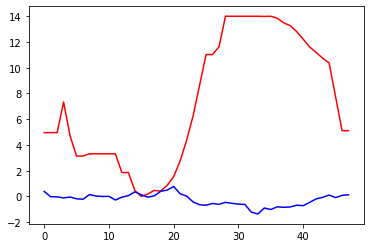

epoch: 1 loss: tensor(53.7599)


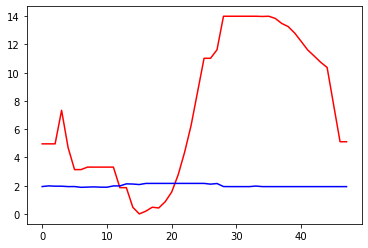

epoch: 2 loss: tensor(47.5483)


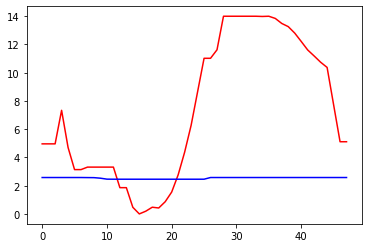

epoch: 3 loss: tensor(42.9296)


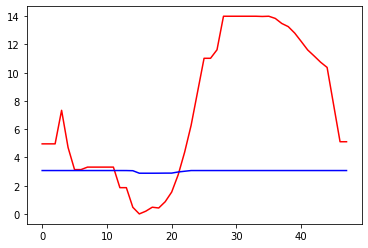

epoch: 4 loss: tensor(38.5141)


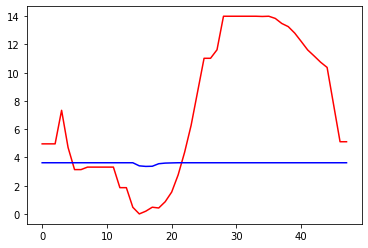

epoch: 5 loss: tensor(34.2679)


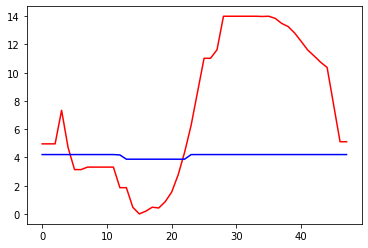

epoch: 6 loss: tensor(30.6835)


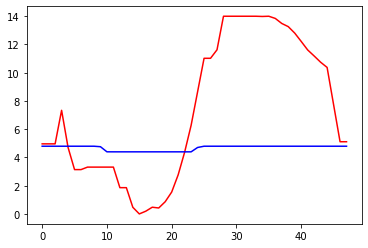

epoch: 7 loss: tensor(27.6707)


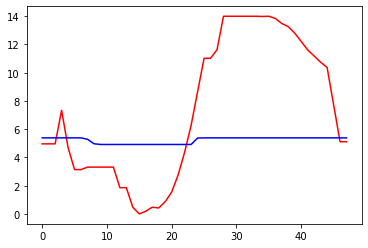

epoch: 8 loss: tensor(25.2946)


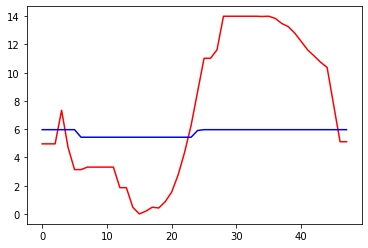

epoch: 9 loss: tensor(23.5643)


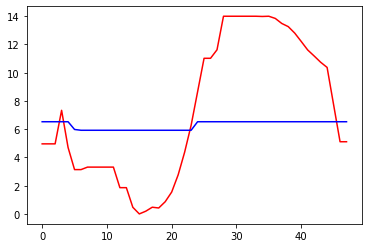

In [17]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

torch.manual_seed(2019)

# 超参设置
TIME_STEP = 1  # RNN时间步长
INPUT_SIZE = 336  # RNN输入尺寸
INIT_LR = 0.035  # 初始学习率
N_EPOCHS = 2  # 训练回数



class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=20,  # RNN隐藏神经元个数
            num_layers=1,  # RNN隐藏层个数
        )
        self.out = nn.Linear(20, 1)#全连接层，经过RNN网络后输出

    def forward(self, x, h):
        # x (time_step, batch_size, input_size)
        # h (n_layers, batch, hidden_size)
        # out (time_step, batch_size, hidden_size)
        out, h = self.rnn(x, h)
        #print("out:",out)
        #print("h:",h)
        prediction = self.out(out)
        #print("prediction:",prediction)
        return prediction, h


rnn = RNN()
#print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=INIT_LR)
loss_func = nn.MSELoss()
#loss_func = torch.nn.CrossEntropyLoss()
h_state = None  # 初始化隐藏层

plt.figure()
plt.ion()
steps=[i for i in range(48)]
for step in range(N_EPOCHS):
        #print(np.array(data_oneday).shape)
        x = torch.from_numpy(np.array(data_oneday).reshape(48,-1,336)).float()  # 尺寸大小为(time_step, batch, input_size)
        print(x.shape)
        y = torch.from_numpy(np.array(soc_test)[:,np.newaxis,np.newaxis]).float()
        #print(y.shape)

        prediction, h_state = rnn(x, h_state)  # RNN输出（预测结果，隐藏状态）
        h_state = h_state.detach()  # 这一行很重要，将每一次输出的中间状态传递下去(不带梯度)
        loss = loss_func(prediction, y)        
        print("epoch:",step,"loss:",loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        plt.cla()
        plt.plot(steps, soc_test, 'r-')
        plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(0.1)
plt.ioff()
plt.show()


In [18]:
#先做一个48个样本的数据集，一个样本336维，分别为前48个SOC值，前48个费率值，后48个费率值，
#前48个需求值，后48个需求值,求第185天的数据
data_oneday=[]
for i in range(48):
    data_temp=[]
    GG_temp=[]
    soc_temp=soc[i:48+i]#前48个SOC（包含当前时刻）
    #print(len(soc_temp))
    data_temp.extend(soc_temp)
    #print(len(data_temp))
    ToU_temp=[]
    load_temp=[]
    if(i==0):
        ToU_temp=np.hstack((T_tou[i:],T_tou))
        load_temp=np.hstack((Total_Load_array[184][i:],Total_Load_array[185]))
        GG_temp=np.hstack((GG[184][i:],GG[185]))
    else:
        ToU_temp=np.hstack((T_tou[i:],T_tou,T_tou[:i]))
        GG_temp=np.hstack((GG[184][i:],GG[185],GG[186][:i]))
        load_temp=np.hstack((Total_Load_array[184][i:],Total_Load_array[185],Total_Load_array[186][:i]))
    data_temp.extend(ToU_temp)
    data_temp.extend(list(map(float, GG_temp)))
    data_temp.extend(load_temp)
    #print(len(data_temp))
    data_oneday.append(data_temp)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)
torch.Size([10, 1, 1])


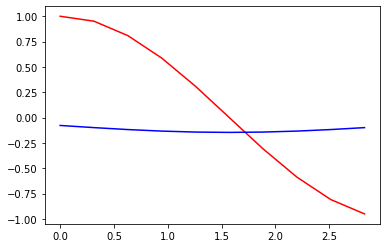

torch.Size([10, 1, 1])


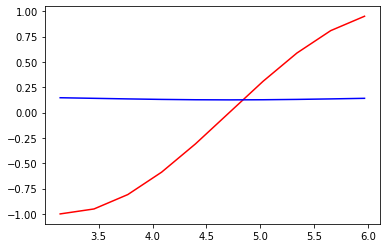

torch.Size([10, 1, 1])


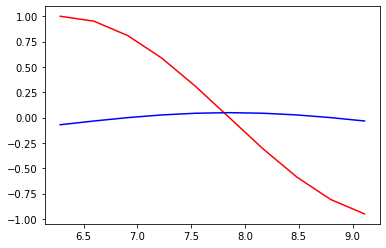

torch.Size([10, 1, 1])


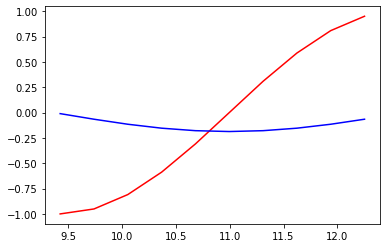

torch.Size([10, 1, 1])


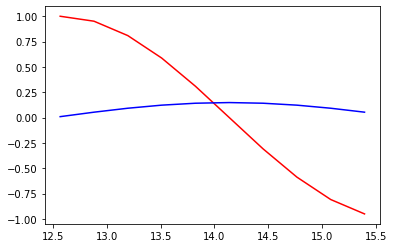

torch.Size([10, 1, 1])


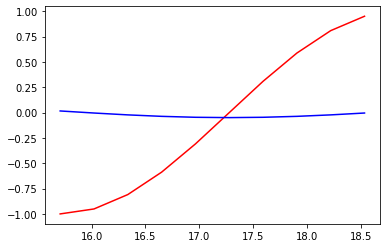

torch.Size([10, 1, 1])


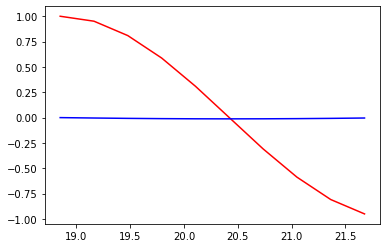

torch.Size([10, 1, 1])


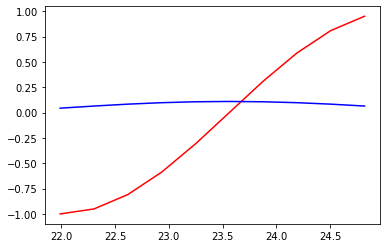

torch.Size([10, 1, 1])


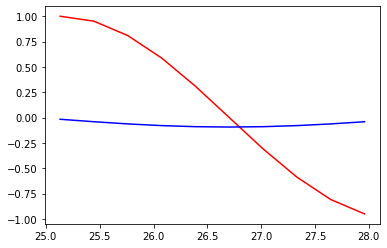

torch.Size([10, 1, 1])


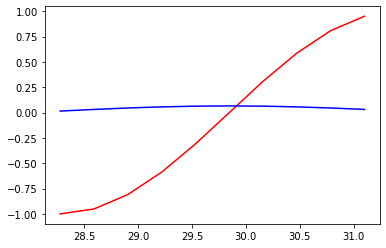

torch.Size([10, 1, 1])


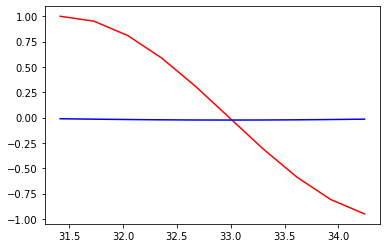

torch.Size([10, 1, 1])


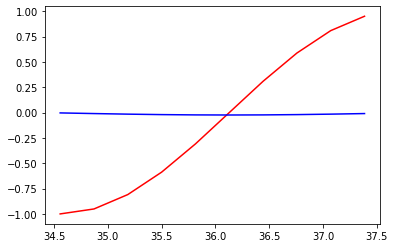

torch.Size([10, 1, 1])


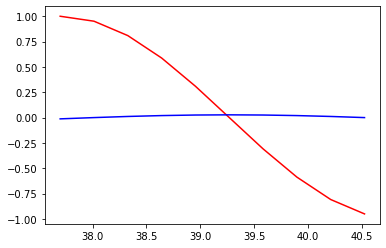

torch.Size([10, 1, 1])


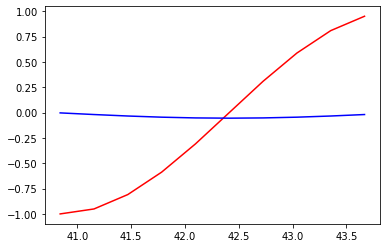

torch.Size([10, 1, 1])


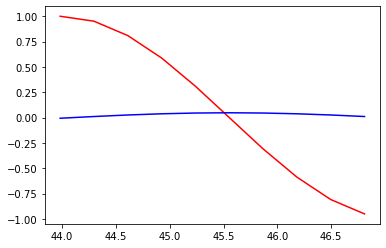

torch.Size([10, 1, 1])


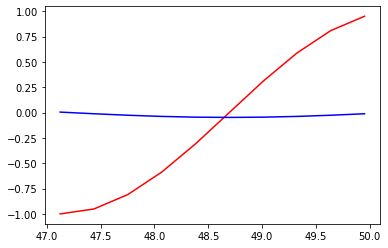

torch.Size([10, 1, 1])


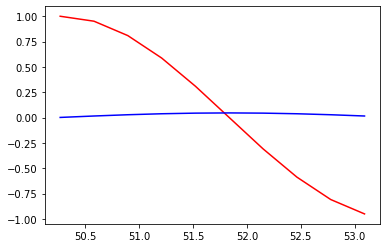

torch.Size([10, 1, 1])


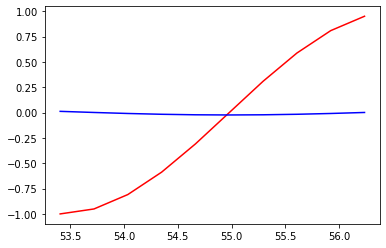

torch.Size([10, 1, 1])


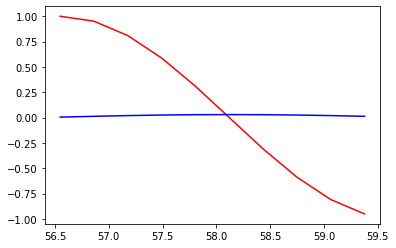

torch.Size([10, 1, 1])


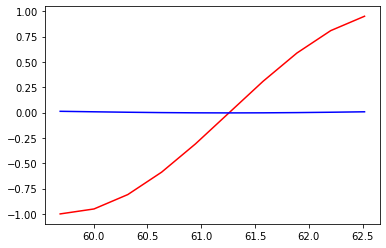

torch.Size([10, 1, 1])


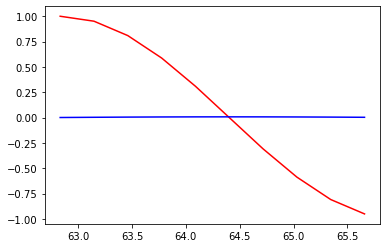

torch.Size([10, 1, 1])


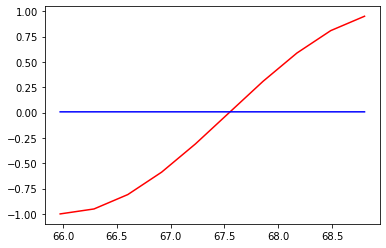

torch.Size([10, 1, 1])


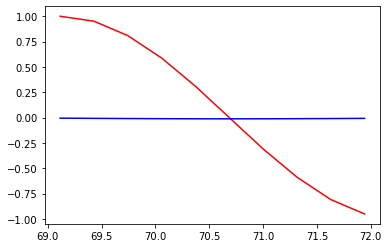

torch.Size([10, 1, 1])


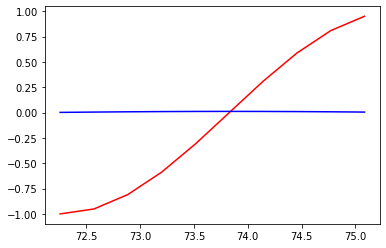

torch.Size([10, 1, 1])


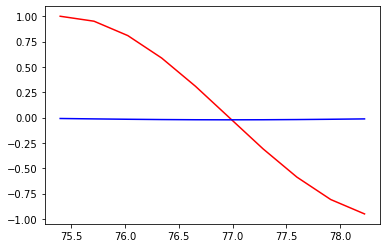

torch.Size([10, 1, 1])


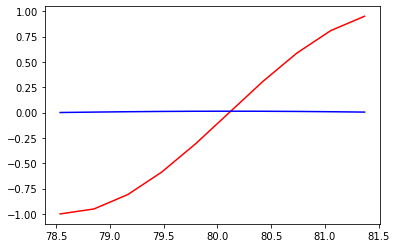

torch.Size([10, 1, 1])


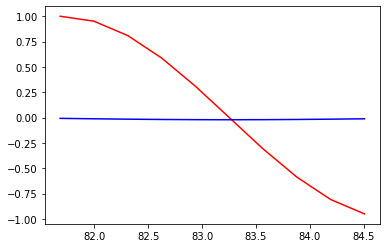

torch.Size([10, 1, 1])


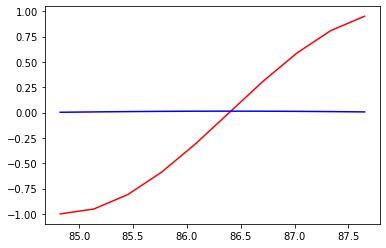

torch.Size([10, 1, 1])


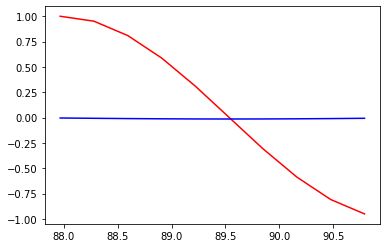

torch.Size([10, 1, 1])


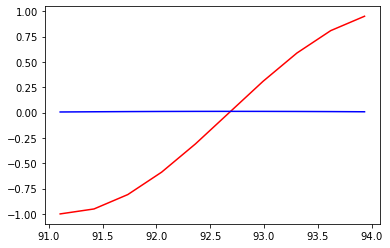

torch.Size([10, 1, 1])


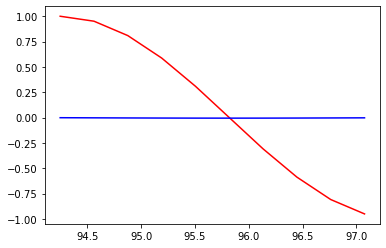

torch.Size([10, 1, 1])


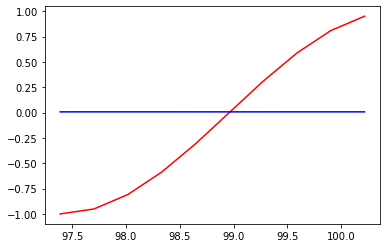

torch.Size([10, 1, 1])


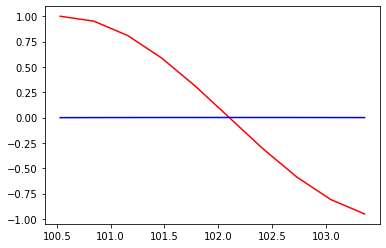

torch.Size([10, 1, 1])


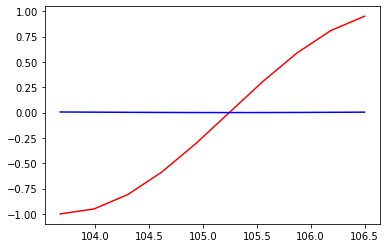

torch.Size([10, 1, 1])


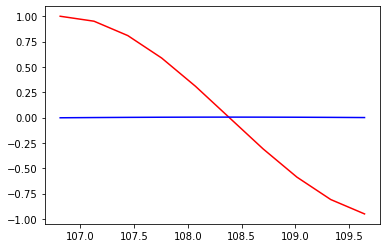

torch.Size([10, 1, 1])


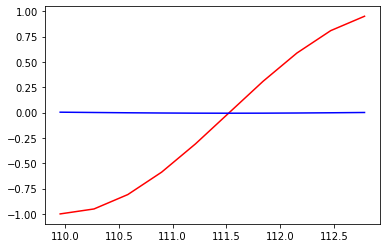

torch.Size([10, 1, 1])


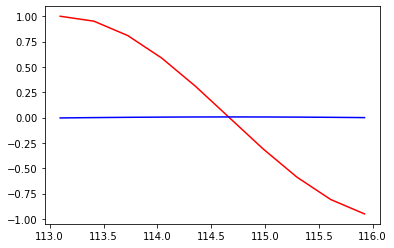

torch.Size([10, 1, 1])


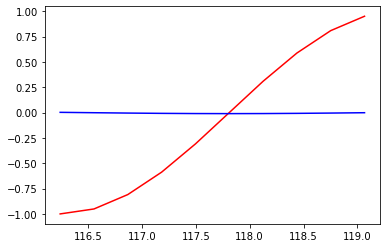

torch.Size([10, 1, 1])


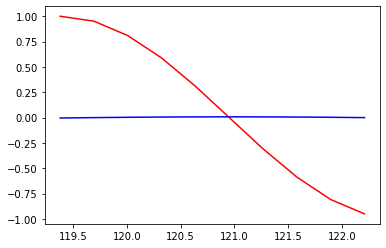

torch.Size([10, 1, 1])


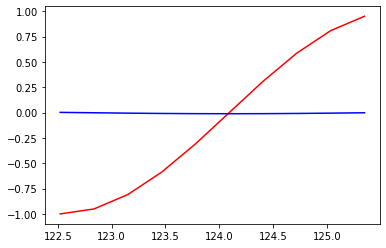

torch.Size([10, 1, 1])


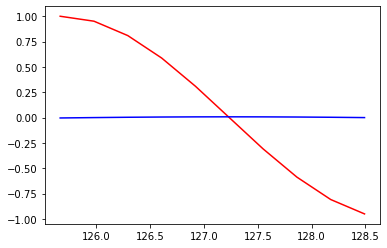

torch.Size([10, 1, 1])


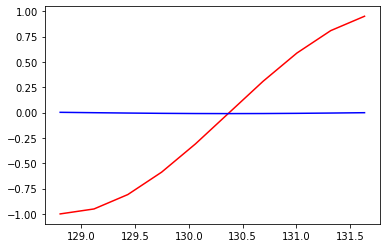

torch.Size([10, 1, 1])


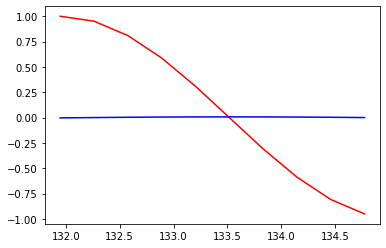

torch.Size([10, 1, 1])


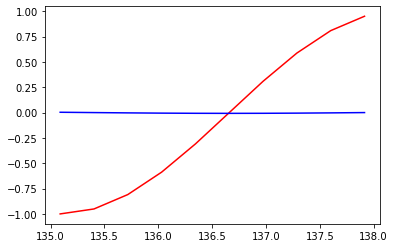

torch.Size([10, 1, 1])


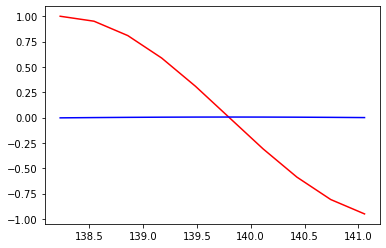

torch.Size([10, 1, 1])


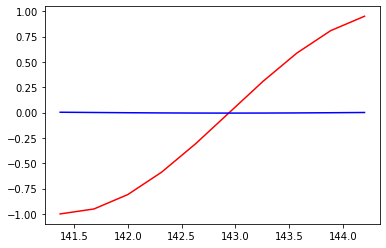

torch.Size([10, 1, 1])


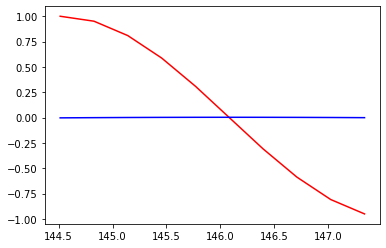

torch.Size([10, 1, 1])


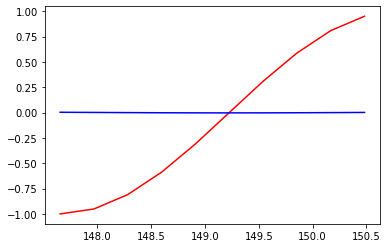

torch.Size([10, 1, 1])


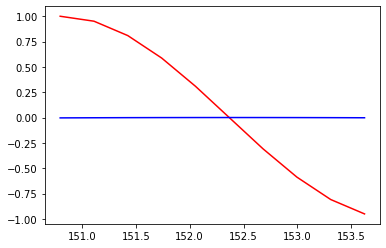

torch.Size([10, 1, 1])


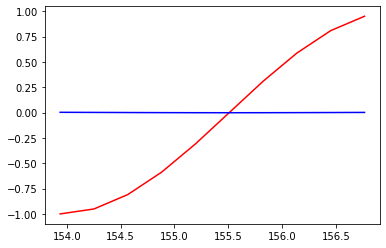

torch.Size([10, 1, 1])


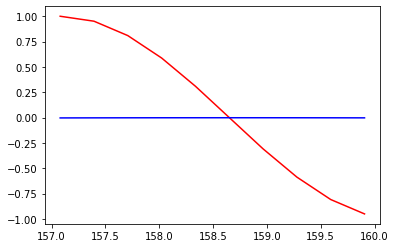

torch.Size([10, 1, 1])


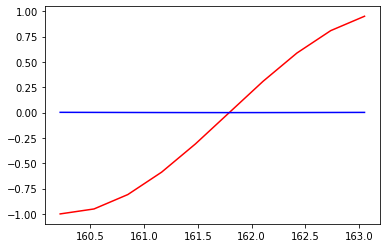

torch.Size([10, 1, 1])


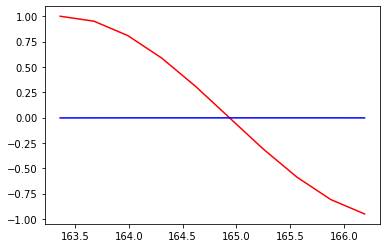

torch.Size([10, 1, 1])


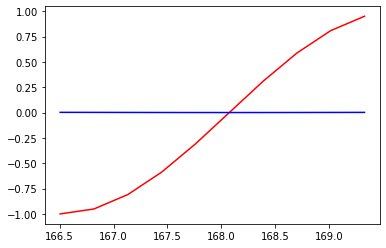

torch.Size([10, 1, 1])


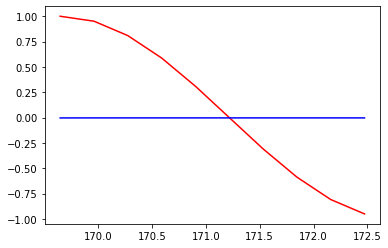

torch.Size([10, 1, 1])


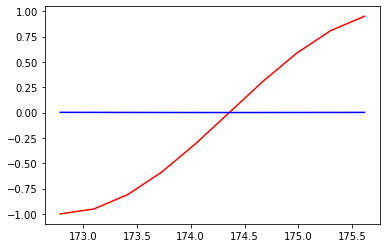

torch.Size([10, 1, 1])


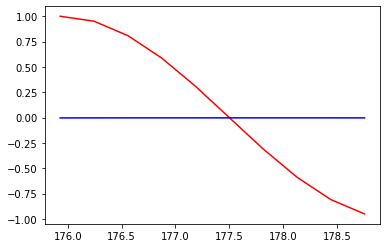

torch.Size([10, 1, 1])


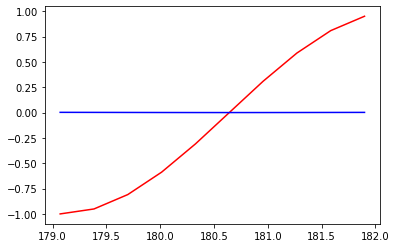

torch.Size([10, 1, 1])


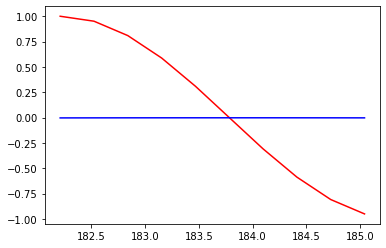

torch.Size([10, 1, 1])


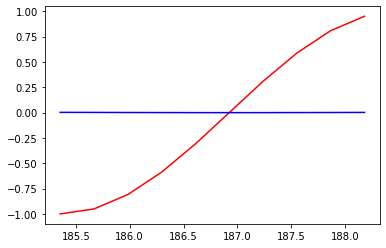

torch.Size([10, 1, 1])


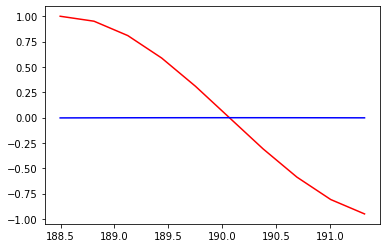

torch.Size([10, 1, 1])


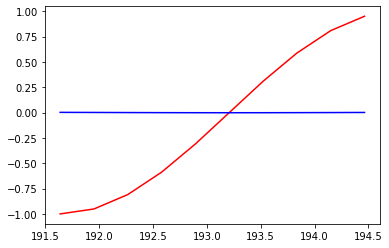

torch.Size([10, 1, 1])


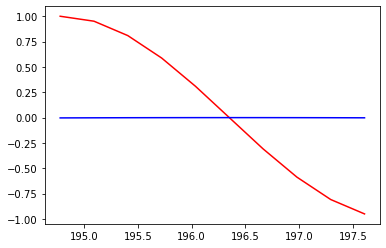

torch.Size([10, 1, 1])


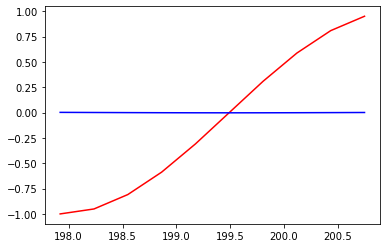

torch.Size([10, 1, 1])


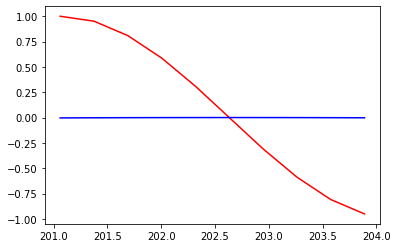

torch.Size([10, 1, 1])


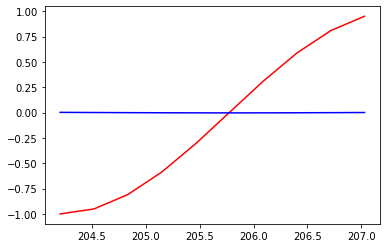

torch.Size([10, 1, 1])


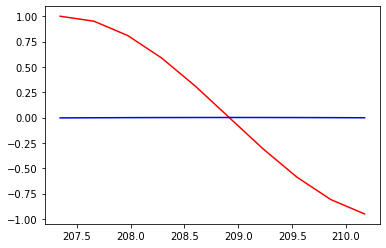

torch.Size([10, 1, 1])


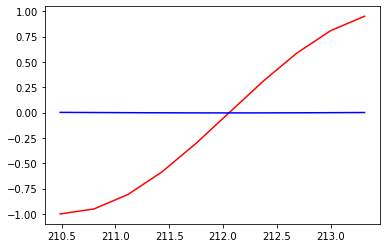

torch.Size([10, 1, 1])


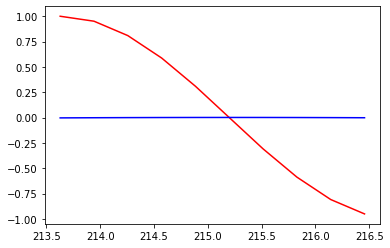

torch.Size([10, 1, 1])


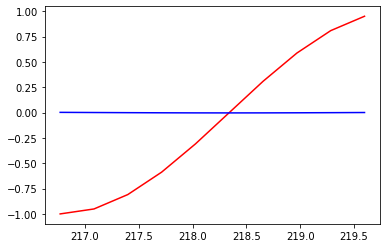

In [43]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(2019)

# 超参设置
TIME_STEP = 10  # RNN时间步长
INPUT_SIZE = 1  # RNN输入尺寸
INIT_LR = 0.02  # 初始学习率
N_EPOCHS =70 # 训练回数


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,  # RNN隐藏神经元个数
            num_layers=1,  # RNN隐藏层个数
            #batch_first=True
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h):
        # x (time_step, batch_size, input_size)
        # h (n_layers, batch, hidden_size)
        # out (time_step, batch_size, hidden_size)
        out, h = self.rnn(x, h)
        prediction = self.out(out)
        return prediction, h


rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=INIT_LR)
loss_func = nn.MSELoss()
h_state = None  # 初始化隐藏层

plt.figure()
plt.ion()
for step in range(N_EPOCHS):
    start, end = step * np.pi, (step + 1) * np.pi  # 时间跨度
    # 使用Sin函数预测Cos函数
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32, endpoint=False)
    x_np = np.sin(steps)
    #print(x_np.shape)
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[:, np.newaxis, np.newaxis])  # 尺寸大小为(time_step, batch, input_size)
    print(x.shape)
    y = torch.from_numpy(y_np[:, np.newaxis, np.newaxis])

    prediction, h_state = rnn(x, h_state)  # RNN输出（预测结果，隐藏状态）
    h_state = h_state.detach()  # 这一行很重要，将每一次输出的中间状态传递下去(不带梯度)
    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 绘制中间结果
    plt.cla()
    plt.plot(steps, y_np, 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw()
    plt.pause(0.1)
plt.ioff()
plt.show()
